# DMT

In [2]:
import sys

sys.path.append("../src")

from environments import LineEnv, GridEnv, MazeEnv
from policies import BaseAgent, QLearningAgent
import matplotlib.pyplot as plt
import networkx as nx


import numpy as np

In [17]:
env = MazeEnv()
agent = BaseAgent(env, gamma=1)
agent.value_iteration()
optimal_value_function = agent.value_function

print("Optimal Value Function:", agent.value_function)
print("Optimal Policy:", agent.policy)

Optimal Value Function: [-14. -13. -12. -11. -14. -13. -14. -15. -14. -10. -11. -12.  -8.  -9.
 -11. -10.  -9.  -8.  -7. -11.  -6.  -5.  -4. -14. -13. -12. -13.  -3.
 -14. -14. -15.  -1.  -2. -15.   0.]
Optimal Policy: [0 1 1 0 1 0 3 1 2 0 3 0 0 3 1 1 1 1 0 2 1 1 0 1 1 2 3 0 2 2 3 0 3 2 0]


In [19]:
env = MazeEnv()
agent = QLearningAgent(env, gamma=1, alpha=0.1)
agent.compute_optimal_q_function()
optimal_q_function = agent.q_table

Optimal Q-function computed.


In [22]:
# check if optimal q is optimal v
np.all(np.max(agent.q_table, axis=-1) == optimal_value_function)

True

# env to graph

TODO: Must be careful about nodes and edges and double counting edges. Define graph exactly as needed. Otherwise we have a wonky discrete morse function calculation. i.e. and edge is defined as connecting two states iff you actually move to that state (no bonking to a wall)

In [25]:

env._state_to_grid.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

In [26]:
# Create a directed graph
G = nx.Graph()

# Add vertices (states) to the graph
for state in env._state_to_grid.keys():
    G.add_node(state)

# Add edges (actions) to the graph
for state in G.nodes:
    for action in range(4):  # There are four possible actions: up, right, down, left
        next_state, reward = env.get_next_state_and_reward(state, action)
        G.add_edge(state, next_state)

# Now G is the graph representation of the environment
G.nodes(), G.edges(data=True)

(NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34)),
 EdgeDataView([(0, 5, {}), (0, 0, {}), (1, 8, {}), (1, 2, {}), (1, 1, {}), (2, 2, {}), (2, 3, {}), (3, 9, {}), (3, 3, {}), (4, 4, {}), (4, 5, {}), (5, 11, {}), (5, 6, {}), (6, 6, {}), (6, 7, {}), (7, 7, {}), (7, 8, {}), (8, 8, {}), (9, 13, {}), (9, 10, {}), (9, 9, {}), (10, 10, {}), (11, 14, {}), (11, 11, {}), (12, 18, {}), (12, 13, {}), (12, 12, {}), (13, 13, {}), (14, 14, {}), (14, 15, {}), (15, 19, {}), (15, 16, {}), (15, 15, {}), (16, 16, {}), (16, 17, {}), (17, 17, {}), (17, 18, {}), (18, 20, {}), (18, 18, {}), (19, 25, {}), (19, 19, {}), (20, 20, {}), (20, 21, {}), (21, 21, {}), (21, 22, {}), (22, 27, {}), (22, 22, {}), (23, 23, {}), (23, 24, {}), (24, 28, {}), (24, 25, {}), (24, 24, {}), (25, 25, {}), (25, 26, {}), (26, 29, {}), (26, 26, {}), (27, 32, {}), (27, 27, {}), (28, 33, {}), (28, 28, {}), (29, 29, {}), (29, 30, {}), (30, 30, {}),

In [28]:
# Step 1: Define a Real-Valued Function on the Graph
# Assigning a random value to each node
node_values = {node: float(optimal_value_function[node]) for node in G.nodes}
edge_values = {(u, v): max(node_values[u], node_values[v]) for u, v in G.edges}

# Adding the values as a node attribute
nx.set_node_attributes(G, node_values, "node_value")
nx.set_edge_attributes(G, edge_values, "edge_value")

In [35]:
list(G.nodes(data=True))[:10]

[(0, {'node_value': -14.0}),
 (1, {'node_value': -13.0}),
 (2, {'node_value': -12.0}),
 (3, {'node_value': -11.0}),
 (4, {'node_value': -14.0}),
 (5, {'node_value': -13.0}),
 (6, {'node_value': -14.0}),
 (7, {'node_value': -15.0}),
 (8, {'node_value': -14.0}),
 (9, {'node_value': -10.0})]

In [36]:
list(G.edges(data=True))[:10]

[(0, 5, {'edge_value': -13.0}),
 (0, 0, {'edge_value': -14.0}),
 (1, 8, {'edge_value': -13.0}),
 (1, 2, {'edge_value': -12.0}),
 (1, 1, {'edge_value': -13.0}),
 (2, 2, {'edge_value': -12.0}),
 (2, 3, {'edge_value': -11.0}),
 (3, 9, {'edge_value': -10.0}),
 (3, 3, {'edge_value': -11.0}),
 (4, 4, {'edge_value': -14.0})]

In [41]:
import networkx as nx

# Assuming G is your graph object


def classify_critical_point(node, G):
    node_value = G.nodes[node]["node_value"]
    neighbors = list(G.neighbors(node))

    higher = lower = 0
    for neighbor in neighbors:
        if G.nodes[neighbor]["node_value"] > node_value:
            higher += 1
        elif G.nodes[neighbor]["node_value"] < node_value:
            lower += 1

    if higher == 0 and lower > 0:
        return "local maximum"
    elif lower == 0 and higher > 0:
        return "local minimum"
    elif higher > 0 and lower > 0:
        return "saddle point"
    else:
        return "flat"


def find_critical_points(G):
    critical_points = {}
    for node in G.nodes:
        critical_type = classify_critical_point(node, G)
        if critical_type != "flat":
            critical_points[node] = critical_type
    return critical_points


critical_points = find_critical_points(G)
print(critical_points)

{0: 'local minimum', 1: 'saddle point', 2: 'saddle point', 3: 'saddle point', 4: 'local minimum', 5: 'saddle point', 6: 'saddle point', 7: 'local minimum', 8: 'saddle point', 9: 'saddle point', 10: 'local minimum', 11: 'saddle point', 12: 'saddle point', 13: 'saddle point', 14: 'saddle point', 15: 'saddle point', 16: 'saddle point', 17: 'saddle point', 18: 'saddle point', 19: 'saddle point', 20: 'saddle point', 21: 'saddle point', 22: 'saddle point', 23: 'local minimum', 24: 'saddle point', 25: 'saddle point', 26: 'saddle point', 27: 'saddle point', 28: 'saddle point', 29: 'saddle point', 30: 'local minimum', 31: 'saddle point', 32: 'saddle point', 33: 'local minimum', 34: 'local maximum'}


In [43]:
critical_points

{0: 'local minimum',
 1: 'saddle point',
 2: 'saddle point',
 3: 'saddle point',
 4: 'local minimum',
 5: 'saddle point',
 6: 'saddle point',
 7: 'local minimum',
 8: 'saddle point',
 9: 'saddle point',
 10: 'local minimum',
 11: 'saddle point',
 12: 'saddle point',
 13: 'saddle point',
 14: 'saddle point',
 15: 'saddle point',
 16: 'saddle point',
 17: 'saddle point',
 18: 'saddle point',
 19: 'saddle point',
 20: 'saddle point',
 21: 'saddle point',
 22: 'saddle point',
 23: 'local minimum',
 24: 'saddle point',
 25: 'saddle point',
 26: 'saddle point',
 27: 'saddle point',
 28: 'saddle point',
 29: 'saddle point',
 30: 'local minimum',
 31: 'saddle point',
 32: 'saddle point',
 33: 'local minimum',
 34: 'local maximum'}

In [58]:
import networkx as nx


def classify_points(G):
    critical_vertices = []
    regular_vertices = []
    critical_edges = []
    regular_edges = []
    invalid_simplices = []

    # Classify vertices
    for v, data in G.nodes(data=True):
        node_value = data["node_value"]
        cofaces = [e for e in G.edges(v, data=True) if e[2]["edge_value"] >= node_value]

        if len(cofaces) == G.degree(v):
            critical_vertices.append(v)
        elif len(cofaces) == G.degree(v) - 1:
            regular_vertices.append(v)
        else:
            invalid_simplices.append(v)

    # Classify edges
    for u, v, data in G.edges(data=True):
        edge_value = data["edge_value"]
        faces = [u, v]

        if all(G.nodes[f]["node_value"] <= edge_value for f in faces):
            critical_edges.append((u, v))
        elif sum(G.nodes[f]["node_value"] > edge_value for f in faces) == 1:
            regular_edges.append((u, v))
        else:
            invalid_simplices.append((u, v))

    # Check for invalid simplices
    is_morse_function = len(invalid_simplices) == 0

    return {
        "is_morse_function": is_morse_function,
        "critical_vertices": critical_vertices,
        "regular_vertices": regular_vertices,
        "critical_edges": critical_edges,
        "regular_edges": regular_edges,
        "invalid_simplices": invalid_simplices,
    }


# Example usage
# G = nx.Graph()
# Here you should add your nodes and edges with their respective values
# ...

result = classify_points(G)
if result["is_morse_function"]:
    print("It's a discrete Morse function!")
    print("Critical Vertices:", result["critical_vertices"])
    print("Regular Vertices:", result["regular_vertices"])
    print("Critical Edges:", result["critical_edges"])
    print("Regular Edges:", result["regular_edges"])
else:
    print(
        "Not a discrete Morse function. Invalid simplices:", result["invalid_simplices"]
    )

It's a discrete Morse function!
Critical Vertices: [5]
Regular Vertices: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
Critical Edges: [(0, 5), (0, 0), (1, 8), (1, 2), (1, 1), (2, 2), (2, 3), (3, 9), (3, 3), (4, 4), (4, 5), (5, 11), (5, 6), (6, 6), (6, 7), (7, 7), (7, 8), (8, 8), (9, 13), (9, 10), (9, 9), (10, 10), (11, 14), (11, 11), (12, 18), (12, 13), (12, 12), (13, 13), (14, 14), (14, 15), (15, 19), (15, 16), (15, 15), (16, 16), (16, 17), (17, 17), (17, 18), (18, 20), (18, 18), (19, 25), (19, 19), (20, 20), (20, 21), (21, 21), (21, 22), (22, 27), (22, 22), (23, 23), (23, 24), (24, 28), (24, 25), (24, 24), (25, 25), (25, 26), (26, 29), (26, 26), (27, 32), (27, 27), (28, 33), (28, 28), (29, 29), (29, 30), (30, 30), (31, 34), (31, 32), (31, 31), (32, 32), (33, 33), (34, 34)]
Regular Edges: []


In [57]:
import networkx as nx

# Assuming G is already defined and populated with your nodes and edges


def classify_simplices(G):
    critical_nodes = []
    regular_nodes = []
    critical_edges = []
    regular_edges = []

    # Function to classify nodes
    for node, data in G.nodes(data=True):
        node_value = data["node_value"]
        edges = G.edges(node, data=True)
        exception_count = sum(
            edge_data["edge_value"] < node_value for _, _, edge_data in edges
        )

        if exception_count == 0:
            critical_nodes.append(node)
        elif exception_count == 1:
            regular_nodes.append(node)
        else:
            return None, None, None, None  # Not a discrete Morse function

    # Function to classify edges
    for edge in G.edges(data=True):
        edge_value = edge[2]["edge_value"]
        faces = [edge[0], edge[1]]
        exception_count = sum(
            G.nodes[face]["node_value"] > edge_value for face in faces
        )

        if exception_count == 0:
            critical_edges.append(edge)
        elif exception_count == 1:
            regular_edges.append(edge)
        else:
            return None, None, None, None  # Not a discrete Morse function

    return critical_nodes, regular_nodes, critical_edges, regular_edges


# Run the classification function
critical_nodes, regular_nodes, critical_edges, regular_edges = classify_simplices(G)

# Check if it's a discrete Morse function and print the results
if critical_nodes is not None:
    print("Discrete Morse function found")
    print("Critical Nodes:", critical_nodes)
    print("Regular Nodes:", regular_nodes)
    print("Critical Edges:", critical_edges)
    print("Regular Edges:", regular_edges)
else:
    print("Not a discrete Morse function")

Discrete Morse function found
Critical Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
Regular Nodes: []
Critical Edges: [(0, 5, {'edge_value': -13.0}), (0, 0, {'edge_value': -14.0}), (1, 8, {'edge_value': -13.0}), (1, 2, {'edge_value': -12.0}), (1, 1, {'edge_value': -13.0}), (2, 2, {'edge_value': -12.0}), (2, 3, {'edge_value': -11.0}), (3, 9, {'edge_value': -10.0}), (3, 3, {'edge_value': -11.0}), (4, 4, {'edge_value': -14.0}), (4, 5, {'edge_value': -13.0}), (5, 11, {'edge_value': -12.0}), (5, 6, {'edge_value': -13.0}), (6, 6, {'edge_value': -14.0}), (6, 7, {'edge_value': -14.0}), (7, 7, {'edge_value': -15.0}), (7, 8, {'edge_value': -14.0}), (8, 8, {'edge_value': -14.0}), (9, 13, {'edge_value': -9.0}), (9, 10, {'edge_value': -10.0}), (9, 9, {'edge_value': -10.0}), (10, 10, {'edge_value': -11.0}), (11, 14, {'edge_value': -11.0}), (11, 11, {'edge_value': -12.0}), (12, 18, {'edge_value': -7.0}), (12,

In [55]:
critical_points

{'maxima': [34], 'minima': [0, 4, 7, 10, 23, 30, 33], 'saddle': []}

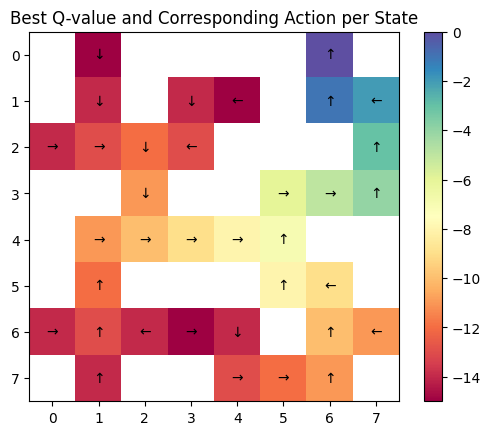

In [56]:
agent.plot_best_action_q_values()